### Предсказание оттока посетителей фитнес-центра   
----------------------

>**Содержание**
<a id='return_to_top'>


>1. [Исследовательский анализ данных (EDA)](#step_2)
2. [Модель прогнозирования оттока пользователей](#step_3)
3. [Кластеризация пользователей](#step_4)
4. [Выводы](#step_5)

<a id='step_2'>

> * **Шаг 2. Проведите исследовательский анализ данных (EDA)**
* Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения (пригодится метод describe());
* Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());
* Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
  Постройте матрицу корреляций и отобразите её.

In [2]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
%matplotlib inline

# для полного отображения содержимого столбцов
pd.set_option('display.max_colwidth', -1)
# импорт sklearn и ее методов/алгоритмов
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
def df_look(df):
    """
    Функция для получения общей информации о датафрейме
    """
    print('Первые 3 строки датафрейма')
    print('-'*52)
    print('{}'.format(df.head(3)))
    print('='*52)
    print('Размер датафрейма: (строк:столбцов) {}'.format(df.shape))
    print('='*52)
    print('Типы данных и общая информация')
    print('-'*52)
    print(df.info())
    print('='*52)
    print('Наличие дубликатов')
    print('='*52)
    print(df.duplicated().sum())
    print('-'*52)
    print('Наличие пропусков')
    print('-'*52)
    print(df.isna().sum())
    print('='*52)

In [4]:
# загружаем данные
path = '/datasets/gym_churn.csv'
df = pd.read_csv(path)

In [5]:
# смотрим на данные
df_look(df)

Первые 3 строки датафрейма
----------------------------------------------------
   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0  1       1              1        1              0      6                 
1  0       1              0        0              1      12                
2  0       1              1        0              1      1                 

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0  1             29   14.227470                     5.0                     
1  1             31   113.202938                    12.0                    
2  0             28   129.448479                    1.0                     

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0  3         0.020398                   0.000000                            
1  7         1.922936                   1.910244                            
2  2         1.859098                   1.736502                           

**С данными все в порядке: дубликатов и пропусков нет, только стоит привести все названия столбцов к нижнему регистру**

In [6]:
# транспонируем датафрейм и оценим показатели методом describe() 
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


* Мужчин и женщин в фитнес-клубе одинаковое количество
* Больше тех кто проживает вблизи фитнеса - 85%
* Почти половина клиентов сотрудники компаний-партнеров
* 30 % приводят друзья
* 90 % пользователей оставляют свой номер телефона
* в основном абонемент покупают на 6 месяцев 
* более 41% посещают груповые занятия
* основной возраст клиентов 29 лет, самому молодому 18 лет, самому старшему 41 год.
* в среднем дополнительные покупки делают на 146 у.е., медианное значение 136 у.е.
* среднее количество месяцев посещения 3,7
* среднее количество посещений в неделю за все время
  практически совпадает с количеством за текущий месяц и составляет ~2 посещения в неделю
* средний отток составляет 26 % 

In [7]:
# формируем список с названиями признаков в нижнем регистре, и переименовываем колонки
lowercase_columns = []
for col in df.columns.tolist():
    col=col.lower()
    lowercase_columns.append(col)
    
df.columns = lowercase_columns
df.head(3)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0


* **Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby())**

In [8]:
lowercase_columns[:-1]

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month']

In [9]:
churn_group = df.groupby('churn')[lowercase_columns[:-1]].mean()

In [10]:
churn_group.transpose()

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


<a id='churn_group'>

>**Выводы**  
---------------
**среди тех кто остался (churn=0) больше тех кто:**
* рядом живет
* сотрудник компании-партнера
* пришел с другом/друзьями
* давно (около полугода) в клубе
* посещает групповые занятия
* кто постарше
* кто больше тратит на доп.услуги (но разница незначительна)
* у кого до конца абонемента еще полгода
* у постоянных клиентов (кто давно в клубе)
* посещает фитнес от 2-х раз в неделю

**Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток); Постройте матрицу корреляций и отобразите её.**

In [11]:
churn_group

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [12]:
# делим каждый признак на сумму признаков  так как их всего 2 в колонке, то на сумму 
# максимального и минимального значения из столбца,
for column in lowercase_columns[:-1]:
    churn_group[column] = (churn_group[column] / (churn_group[column].max()+churn_group[column].min()))

In [13]:
# транспонируем группированную таблицу и переименовываем столбцы
churn_group_new = churn_group.transpose()
churn_group_new.columns = ['exist', 'churn']

In [14]:
churn_group_new

,exist,churn
gender,0.499607,0.500393
near_location,0.531971,0.468029
partner,0.600543,0.399457
promo_friends,0.657947,0.342053
phone,0.500218,0.499782
contract_period,0.768778,0.231222
group_visits,0.633400,0.366600
age,0.526216,0.473784
avg_additional_charges_total,0.579266,0.420734
month_to_end_contract,0.760630,0.239370


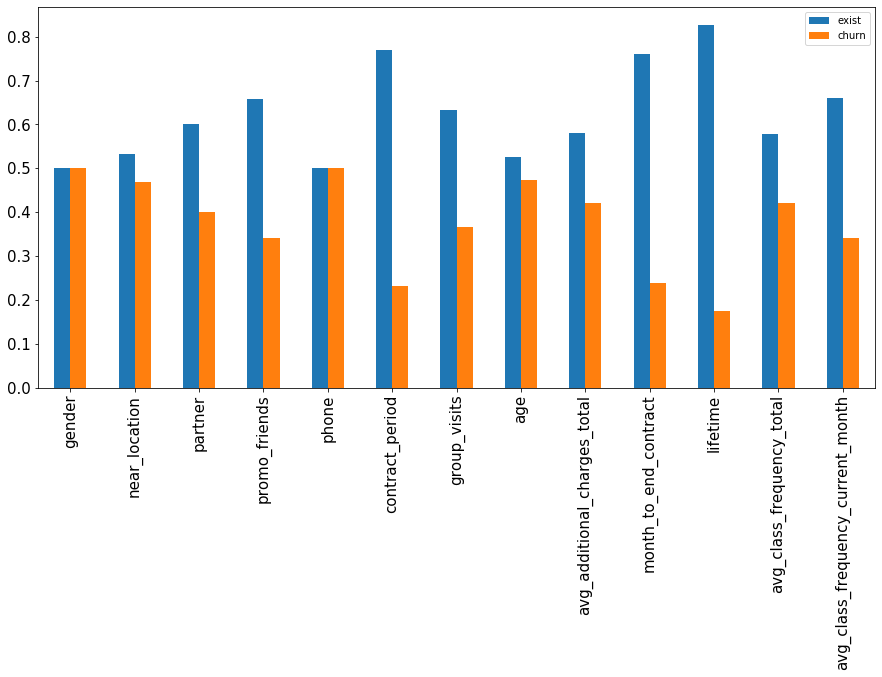

In [15]:
# строим столбчатую диаграмму
churn_group_new.plot(kind='bar',figsize=(15, 7), fontsize=15);

In [16]:
# создаем копию датафрейма и переименовываем значения столбца churn
df_temp = df.copy()

In [17]:
def replacer (df, col, old_value, new_value):
    """
    Производит замену значений в столбцах
    переменные: df, col, old_value, new_value
    """
    for i in col:
        df[col] = df[col].replace(old_value, new_value)

In [18]:
replacer(df_temp, 'churn', [0, 1], ['exist', 'churn'])

In [19]:
df_temp.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,exist
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,exist
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,exist
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,exist
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,exist


In [20]:
def pair_plot(df, start, stop):
    """Функция для построения графиков признаков по показателю оттока"""
    sns.pairplot(df_temp[lowercase_columns[start:stop]+['churn']],\
                 hue='churn', hue_order=['exist','churn'],\
                 palette="husl");

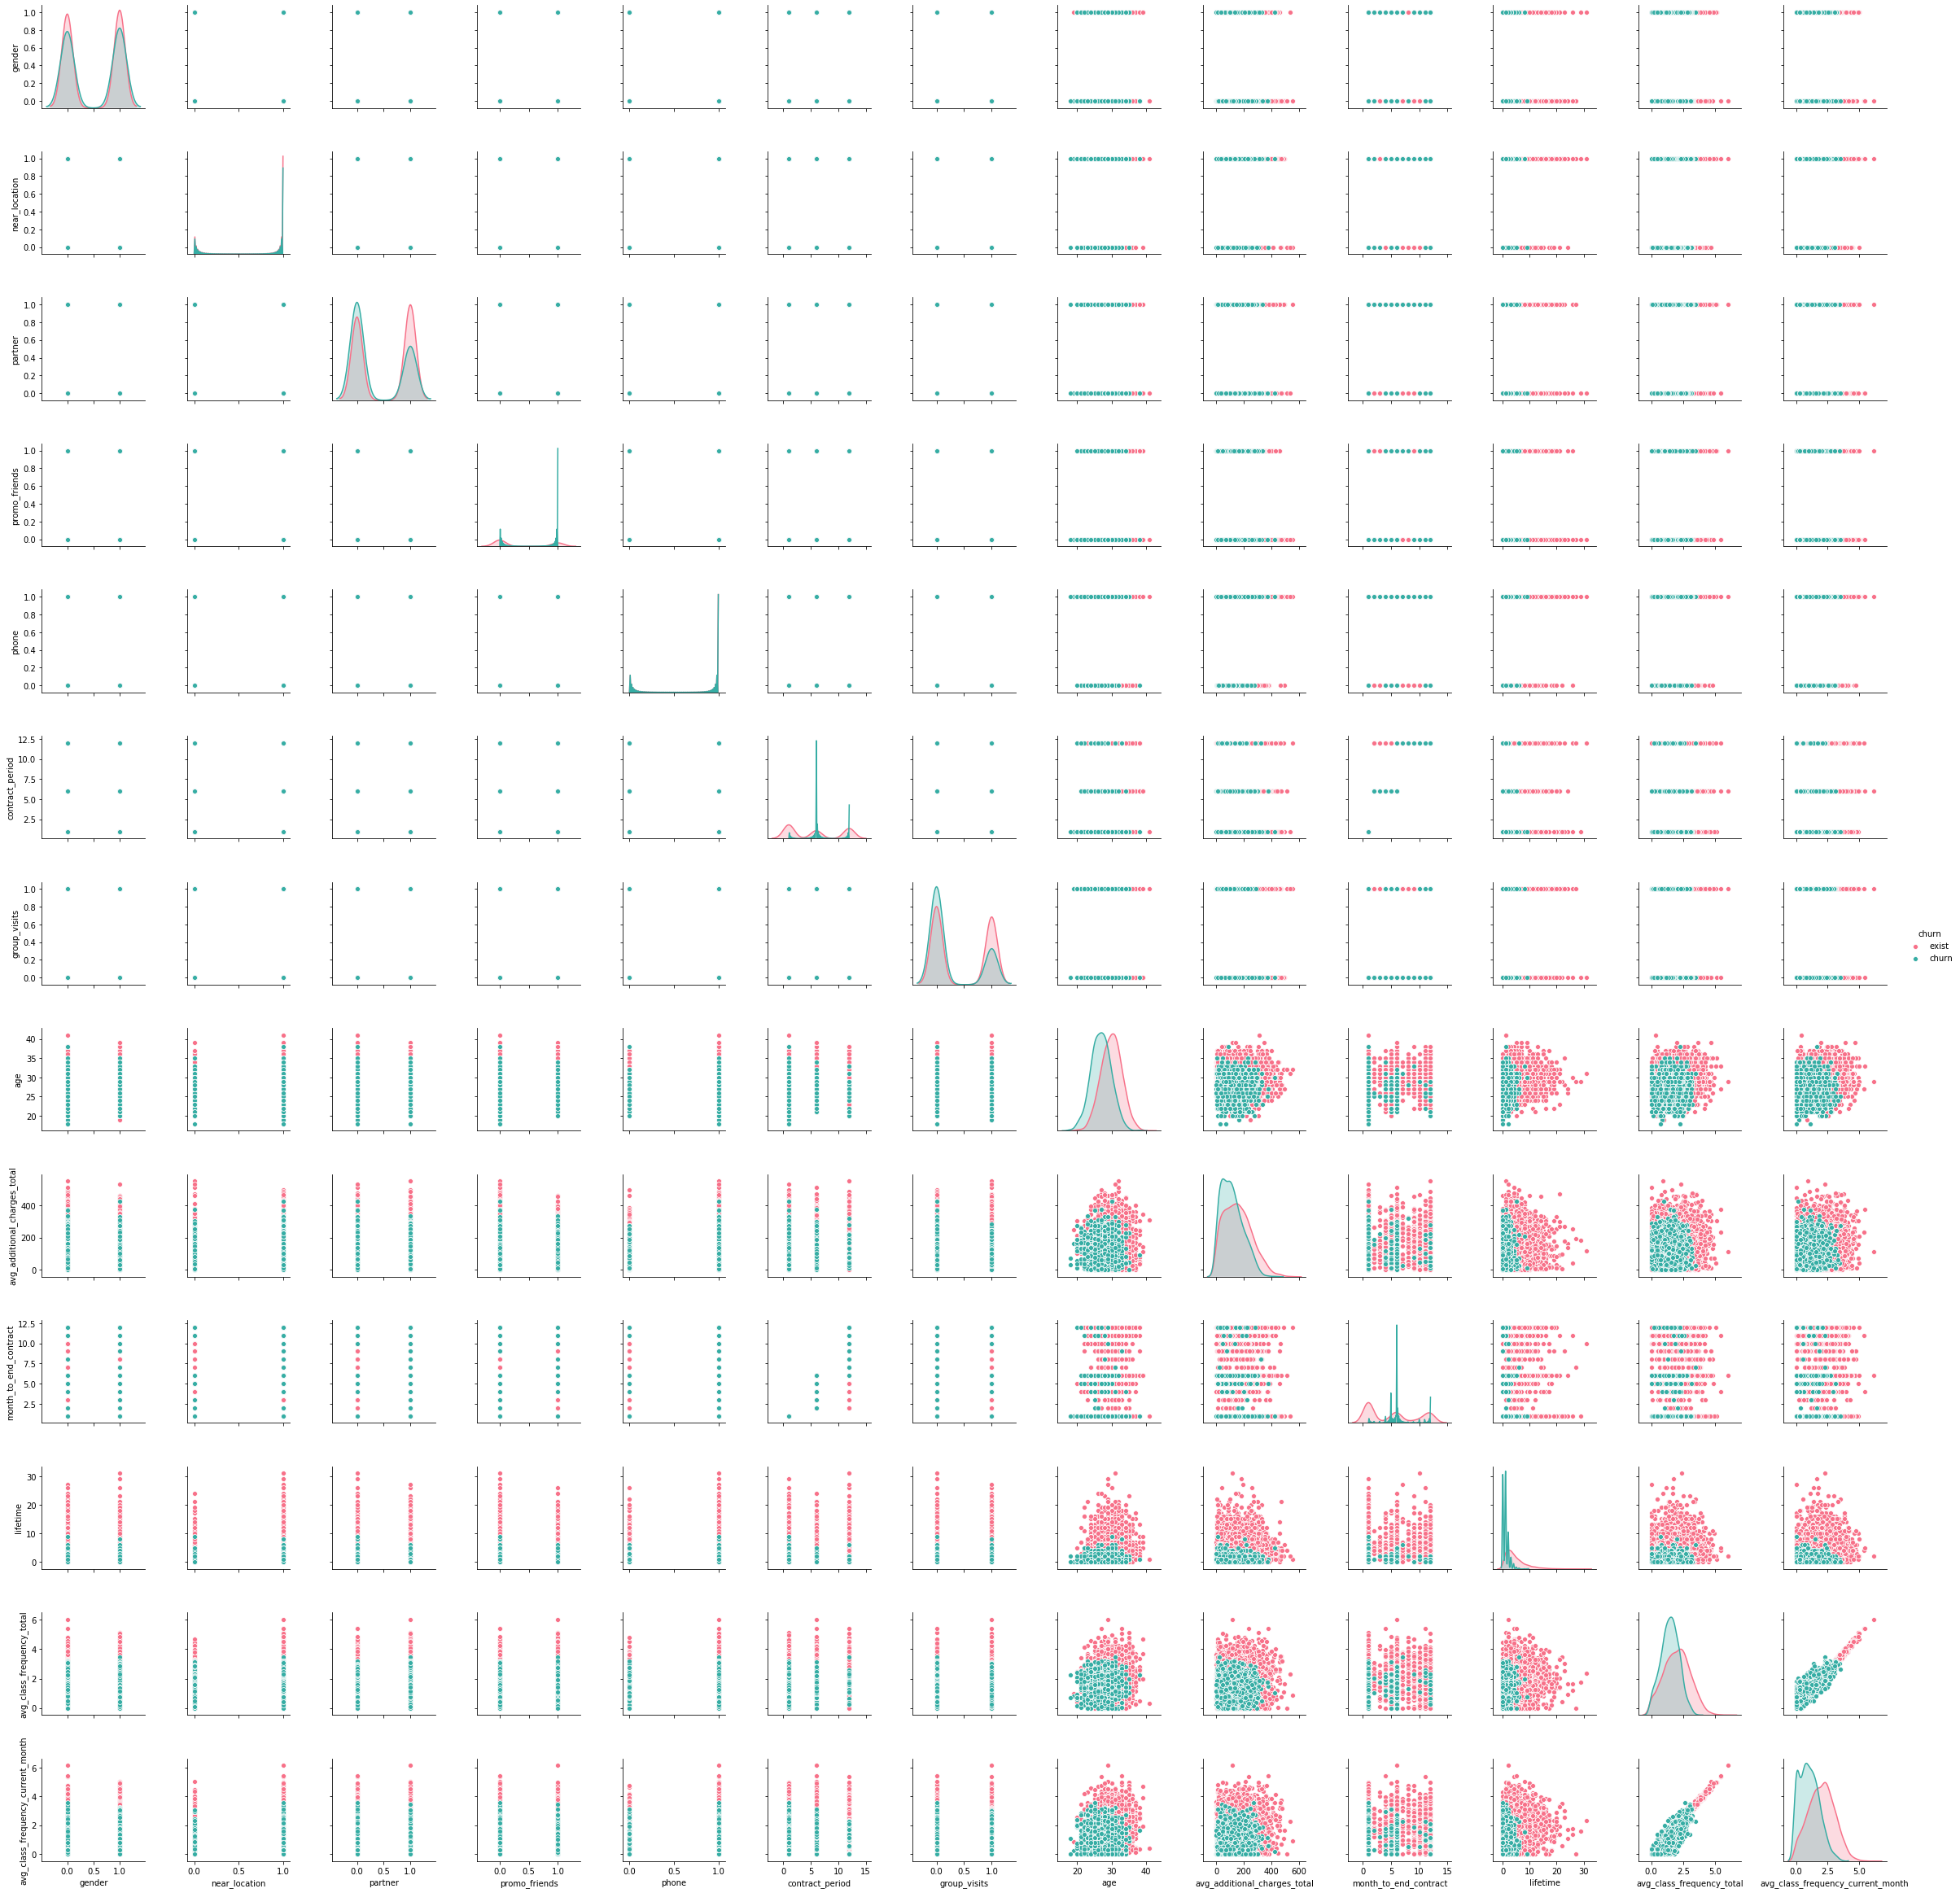

In [20]:
pair_plot(df_temp, 0, 13)

**самые интересные зависимости начинаются с признака с индексом=7 (age), построим их отдельно**

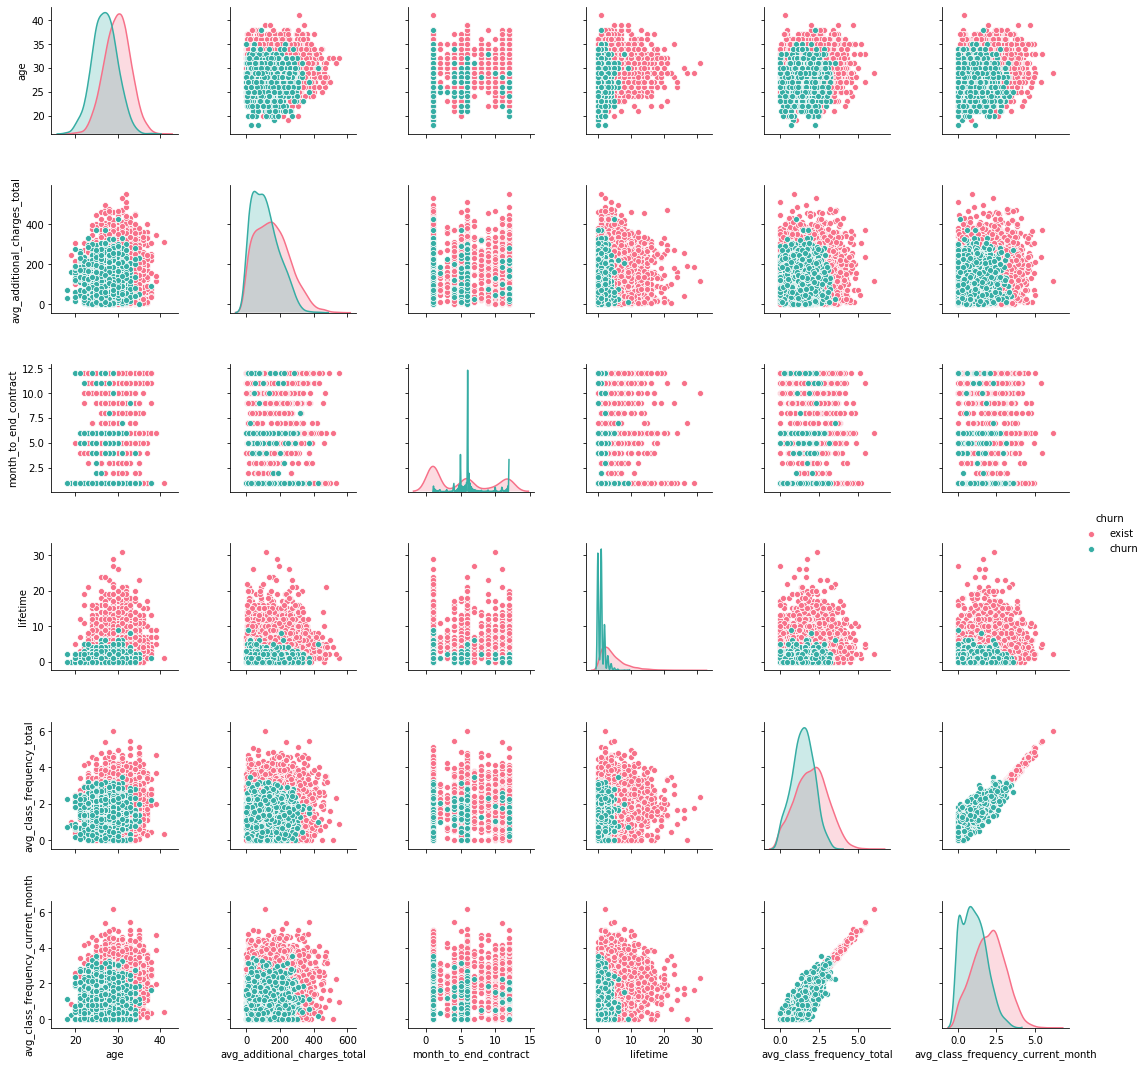

In [21]:
pair_plot(df_temp, 7, 13)

>Распределения признаков подтверждают выводы полученные при анализе признаков сгруппированных по **churn**  
[Выводы по churn_group](#churn_group)

**Построим матрицу корреляций**

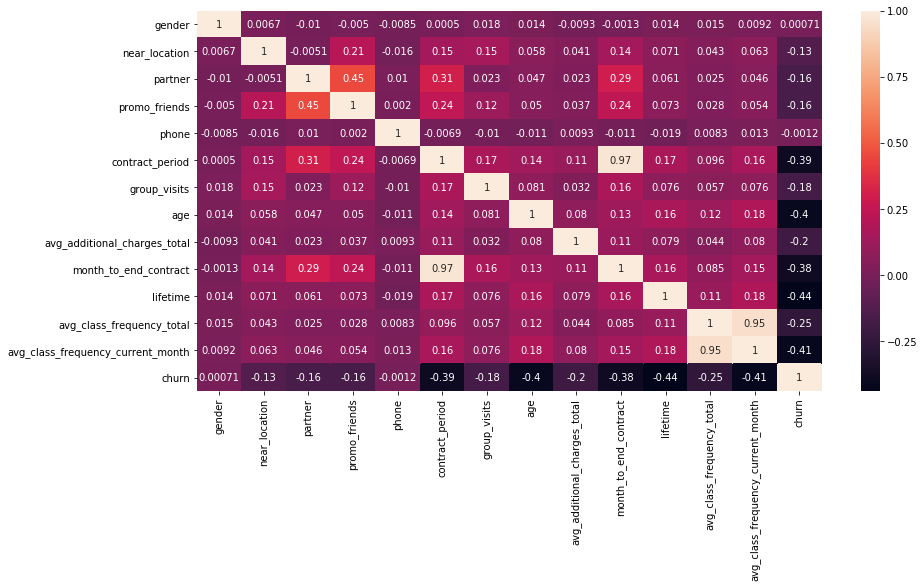

In [22]:
corr = df.corr()
f, ax = plt.subplots(figsize=(14, 7))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True);

**Выводы по матрице корреляций**
* чем больше партнеров и ближе к дому клуб тем выше показатель "приведи друга"
* количество партнеров, близость к дому и наличие друзей также положительно влияют на длительность действующего абонемента

* уровень оттока снижается если:
  * больше друзей
  * ближе к дому
  * больше партнеров
  * клиент постоянный (высокий лайфтайм)
  * человек старше
  * ходит часто и много тратит на доп.услуги
  * посещает групповые занятия
  
признаки: <code>month_to_end_contract</code> и <code>contract_period</code>, а также <code>avg_class_frequency_total</code> и <code>avg_class_frequency_current_month</code> очень сильно коррелируют, так как являются очень близкими показателями, возможно по одному признаку из пары стоит удалить перед обучением.

<a id='step_3'>

> **Модель прогнозирования оттока пользователей**
 * Постройте модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:
 * Разбейте данные на обучающую и валидационную выборку функцией train_test_split().
 * Обучите модель на train-выборке любым двумя способами:
     * логистической регрессией
     * случайным лесом
 * Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель   показала себя лучше на основании метрик?

In [33]:
# X - признаки
features = df.drop(['churn'], axis=1)
# y - целевая переменная
target = df['churn']

In [34]:
# features_train - X_train; features_valid - X_test; target_train - y_train; target_valid - y_test
features_train, features_valid, target_train, target_valid = train_test_split(features,target, test_size=0.2, random_state=42)

In [35]:
# Обучаем модель логистической регрессии
lr_model = LogisticRegression(random_state=42)
lr_model.fit(features_train, target_train)
pred_valid = lr_model.predict(features_valid)
lr_mse = mean_squared_error(target_valid, pred_valid)
lr_rmse = math.sqrt(lr_mse)

In [36]:
# выводим метрики 
print('Логистическая регрессия')
print('='*len('Логистическая регрессия'))
print('RMSE_linear:', lr_rmse)
print('Accuracy:', accuracy_score(target_valid, pred_valid))
print('Precision:', precision_score(target_valid, pred_valid))
print('Recall:', recall_score(target_valid, pred_valid))

Логистическая регрессия
RMSE_linear: 0.2761340254296815
Accuracy: 0.92375
Precision: 0.8895027624309392
Recall: 0.7970297029702971


In [37]:
print('Логистическая регрессия')
print('='*len('Логистическая регрессия'))
print('RMSE_linear:', lr_rmse)
print('Accuracy:', accuracy_score(target_valid, pred_valid))
print('Precision:', precision_score(target_valid, pred_valid))
print('Recall:', recall_score(target_valid, pred_valid))
print()

# обучаем модель "случайный лес"
header_len = '||Estimators| RMSE |Accuracy| Precision|  Recall ||'
print(header_len)
print("="*len(header_len))
print()
print('Случайный лес')
print("="*len(header_len))
for estimator in range(5, 60, 5):
    for i in range(1,5,1):
        rf_model = RandomForestClassifier(n_estimators=estimator, max_depth=i, random_state=42)
        rf_model.fit(features_train, target_train)
        pred_valid = rf_model.predict(features_valid)
        rf_mse = mean_squared_error(target_valid, pred_valid)
        rf_rmse = math.sqrt(rf_mse)
        print()
        print('max_depth',i)
        print('||{: ^10.1f}|{: <6.4f}|{: ^8.4f}|{: ^10.4f}|{: ^9.4f}||'\
              .format(estimator,
                      rf_rmse,
                      accuracy_score(target_valid, pred_valid),
                      precision_score(target_valid, pred_valid),
                      recall_score(target_valid, pred_valid))
                 ) 
    

Логистическая регрессия
RMSE_linear: 0.2761340254296815
Accuracy: 0.92375
Precision: 0.8895027624309392
Recall: 0.7970297029702971

||Estimators| RMSE |Accuracy| Precision|  Recall ||

Случайный лес

max_depth 1
||   5.0    |0.5025| 0.7475 |  0.0000  | 0.0000  ||

max_depth 2
||   5.0    |0.3873| 0.8500 |  0.8727  | 0.4752  ||

max_depth 3
||   5.0    |0.3640| 0.8675 |  0.8871  | 0.5446  ||

max_depth 4
||   5.0    |0.3428| 0.8825 |  0.8913  | 0.6089  ||

max_depth 1
||   10.0   |0.5025| 0.7475 |  0.0000  | 0.0000  ||

max_depth 2
||   10.0   |0.4138| 0.8287 |  0.9577  | 0.3366  ||

max_depth 3
||   10.0   |0.3775| 0.8575 |  0.9231  | 0.4752  ||

max_depth 4
||   10.0   |0.3482| 0.8788 |  0.8571  | 0.6238  ||

max_depth 1
||   15.0   |0.5025| 0.7475 |  0.0000  | 0.0000  ||

max_depth 2
||   15.0   |0.4138| 0.8287 |  0.9333  | 0.3465  ||

max_depth 3
||   15.0   |0.3623| 0.8688 |  0.9076  | 0.5347  ||

max_depth 4
||   15.0   |0.3391| 0.8850 |  0.8767  | 0.6337  ||

max_depth 1
||   20.

**Получается, что лучше подходит модель логистической регрессии**

<a id='step_4'>

**Кластеризация пользователей**

>**Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (пользователей):**
 * Стандартизируйте данные.
 * Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.
 * Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).
 * Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
 * Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
 * Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [38]:
# стандартизаруем данные, удаляем столбец с целевой переменной
sc = StandardScaler()
data=df.drop('churn', axis=1)
x_sc=sc.fit_transform(data)

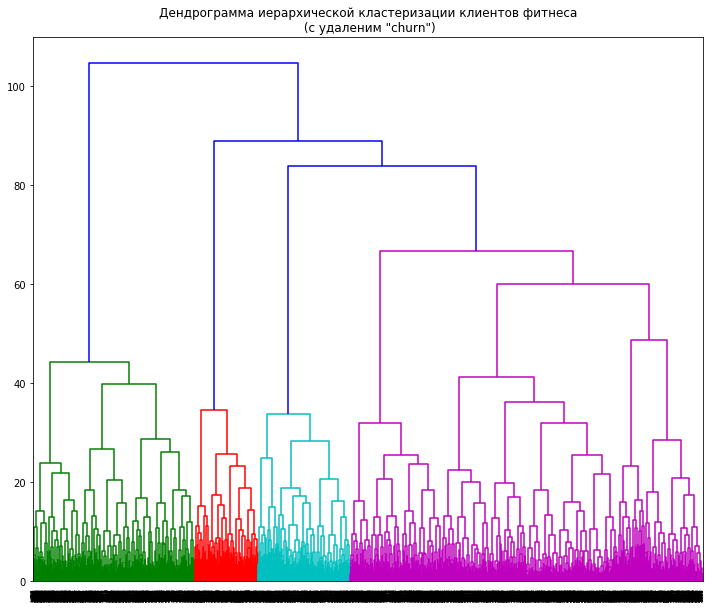

In [39]:
# строим дендрограмму 
plt.figure(figsize=(12,10))
linked = linkage(x_sc, method='ward')
dendrogram(linked, orientation='top')
plt.title('Дендрограмма иерархической кластеризации клиентов фитнеса\n (с удаленим "churn")')
plt.show()

**Дендрограмма построенная с удалением столбца с показателем оттока (churn) дает 4 кластера, причем 4-й кластер выглядит довольно большим, попробуем построить без удаления "churn"**

In [30]:
sc_1 = StandardScaler()
x_sc_1=sc_1.fit_transform(df)

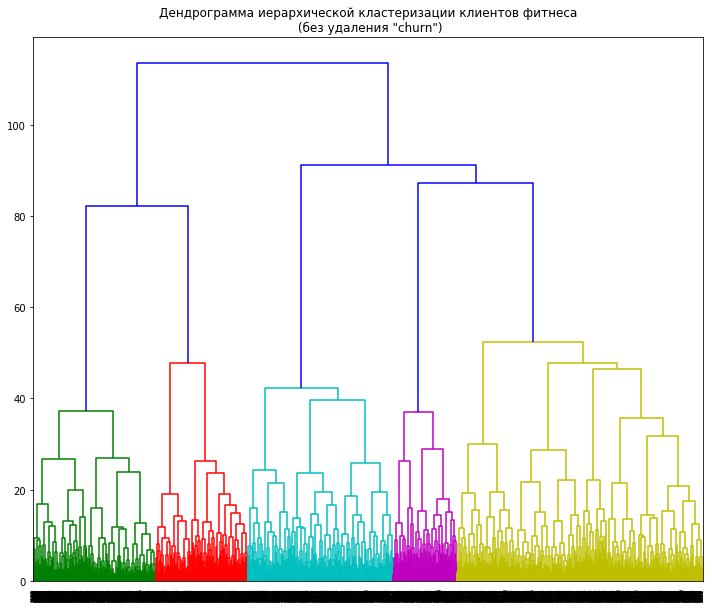

In [31]:
plt.figure(figsize=(12,10))
linked = linkage(x_sc_1, method='ward')
dendrogram(linked, orientation='top')
plt.title('Дендрограмма иерархической кластеризации клиентов фитнеса\n (без удаления "churn")')
plt.show()

**Дендрограмма построенная без удаления столбца с показателем оттока (churn) дает необходимые по заданию 5 кластеров**

**Обучим модель алгоритмом K-Means**

In [40]:
# стандартизируем данные, обучаем модель
sc_km = StandardScaler()
x_sc_km = sc_km.fit_transform(df)
# строим прогноз
km = KMeans(n_clusters=5, random_state=42)
labels = km.fit_predict(x_sc_km)
# добавляем столбец с кластерами и группируем по кластерам, находим среднее
df['cluster_km'] = labels
clusters_grouped = df.groupby('cluster_km').mean()

In [41]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,3
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,1
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,1
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,0


In [44]:
# транспонируем сгруппированную таблицу, переименовываем кластеры
clusters_grouped_new = clusters_grouped.transpose()
clusters_grouped_new.columns = ['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']
clusters_grouped_new

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
gender,0.475029,0.503106,0.550588,0.524804,0.507447
near_location,0.828107,0.938923,0.840000,0.866841,0.760638
partner,0.447154,0.768116,0.375294,0.469974,0.341489
promo_friends,0.254355,0.564182,0.215294,0.308094,0.179787
phone,1.000000,1.000000,0.998824,0.000000,0.997872
contract_period,2.649245,11.173913,2.748235,4.806789,1.567021
group_visits,0.382114,0.557971,0.441176,0.428198,0.257447
age,30.008130,29.899586,29.987059,29.331593,26.908511
avg_additional_charges_total,153.612964,161.514913,160.089533,144.156967,115.109065
month_to_end_contract,2.465738,10.223602,2.527059,4.493473,1.513830


In [45]:
# копируем датафрейм и заменяем цифровое обозначение кластера на категориальное
cluster_df = df.copy()
replacer(cluster_df, 'cluster_km', [0, 1, 2, 3, 4], ['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5'])

In [46]:
def amount(df, cluster):
    print(f'Доля кластера {cluster}:', (df.query('cluster_km==@cluster').shape[0]/df.shape[0])*100, '%')
 
clusters = ['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']

for i in clusters:
    amount(cluster_df, i)

Доля кластера cluster_1: 21.525 %
Доля кластера cluster_2: 24.15 %
Доля кластера cluster_3: 21.25 %
Доля кластера cluster_4: 9.575 %
Доля кластера cluster_5: 23.5 %


>* **Кластеры со склонностью к оттоку (в данном случае это 4 и 5 кластеры)**:
   * в 5 кластере доля оттока почти 100% и он составляет - 23,5 % от всех посетителей
   * в 4 кластере доля оттока 26 %, составляет - 9,575 % от всех посетителей
   * суммарно 4 и 5 составляют 33,075 %  - внушительное количество!
   * пользователей 4 кластера не так много, это как раз те, кто не оставляет телефон, они примерно в середине срока действия        абонемента, возможно очень занятые люди которых бесит рекламная смс-рассылка или они заскучали на групповых занятиях.          Возможно тут нужен индивидуальный подход, например персональный фитнес-тренер 
   * пользователи 5-го кластера:
     * пришли без друзей
     * редко ходят на занятия в том числе на групповые ~ 1 раз в неделю
     * 1,5 месяца до окончания абонемента при лайфтайме 1 месяц - видимо они брали минимальный абонемент(месяц, 3 месяца)
       и им что-то не понравилось
     * возраст 26-27 лет
>

>* **Надежные кластеры: 1, 2, 3**. 
   * Самый надежный 2 кластер, несмотря на показатель оттока 1,5 % больше чем в 1 и 3. 
     * жители района
     * сотрудники компаний-партнеров
     * занимаются с друзьями
     * постоянные клиенты с "длинным" абонементом и платящие за доп.услуги
     * регулярно посещают занятия
   * Кластеры 1 и 3 хотя имеют самый низкий показатель оттока могут быть кандидатами на его повышение
     * нужно поощрять посещения
     * предлагать скидки при приближении окончания абонемента
     

In [47]:
def pair_plot_cluster(df, start, stop):
    """Функция для построения графиков признаков по кластерам"""
    sns.pairplot(df[lowercase_columns[start:stop]+['cluster_km']],\
                 hue='cluster_km', hue_order=clusters,\
                 palette=['magenta', 'navy', 'green', 'red', 'gray'], plot_kws={'alpha': 0.6})

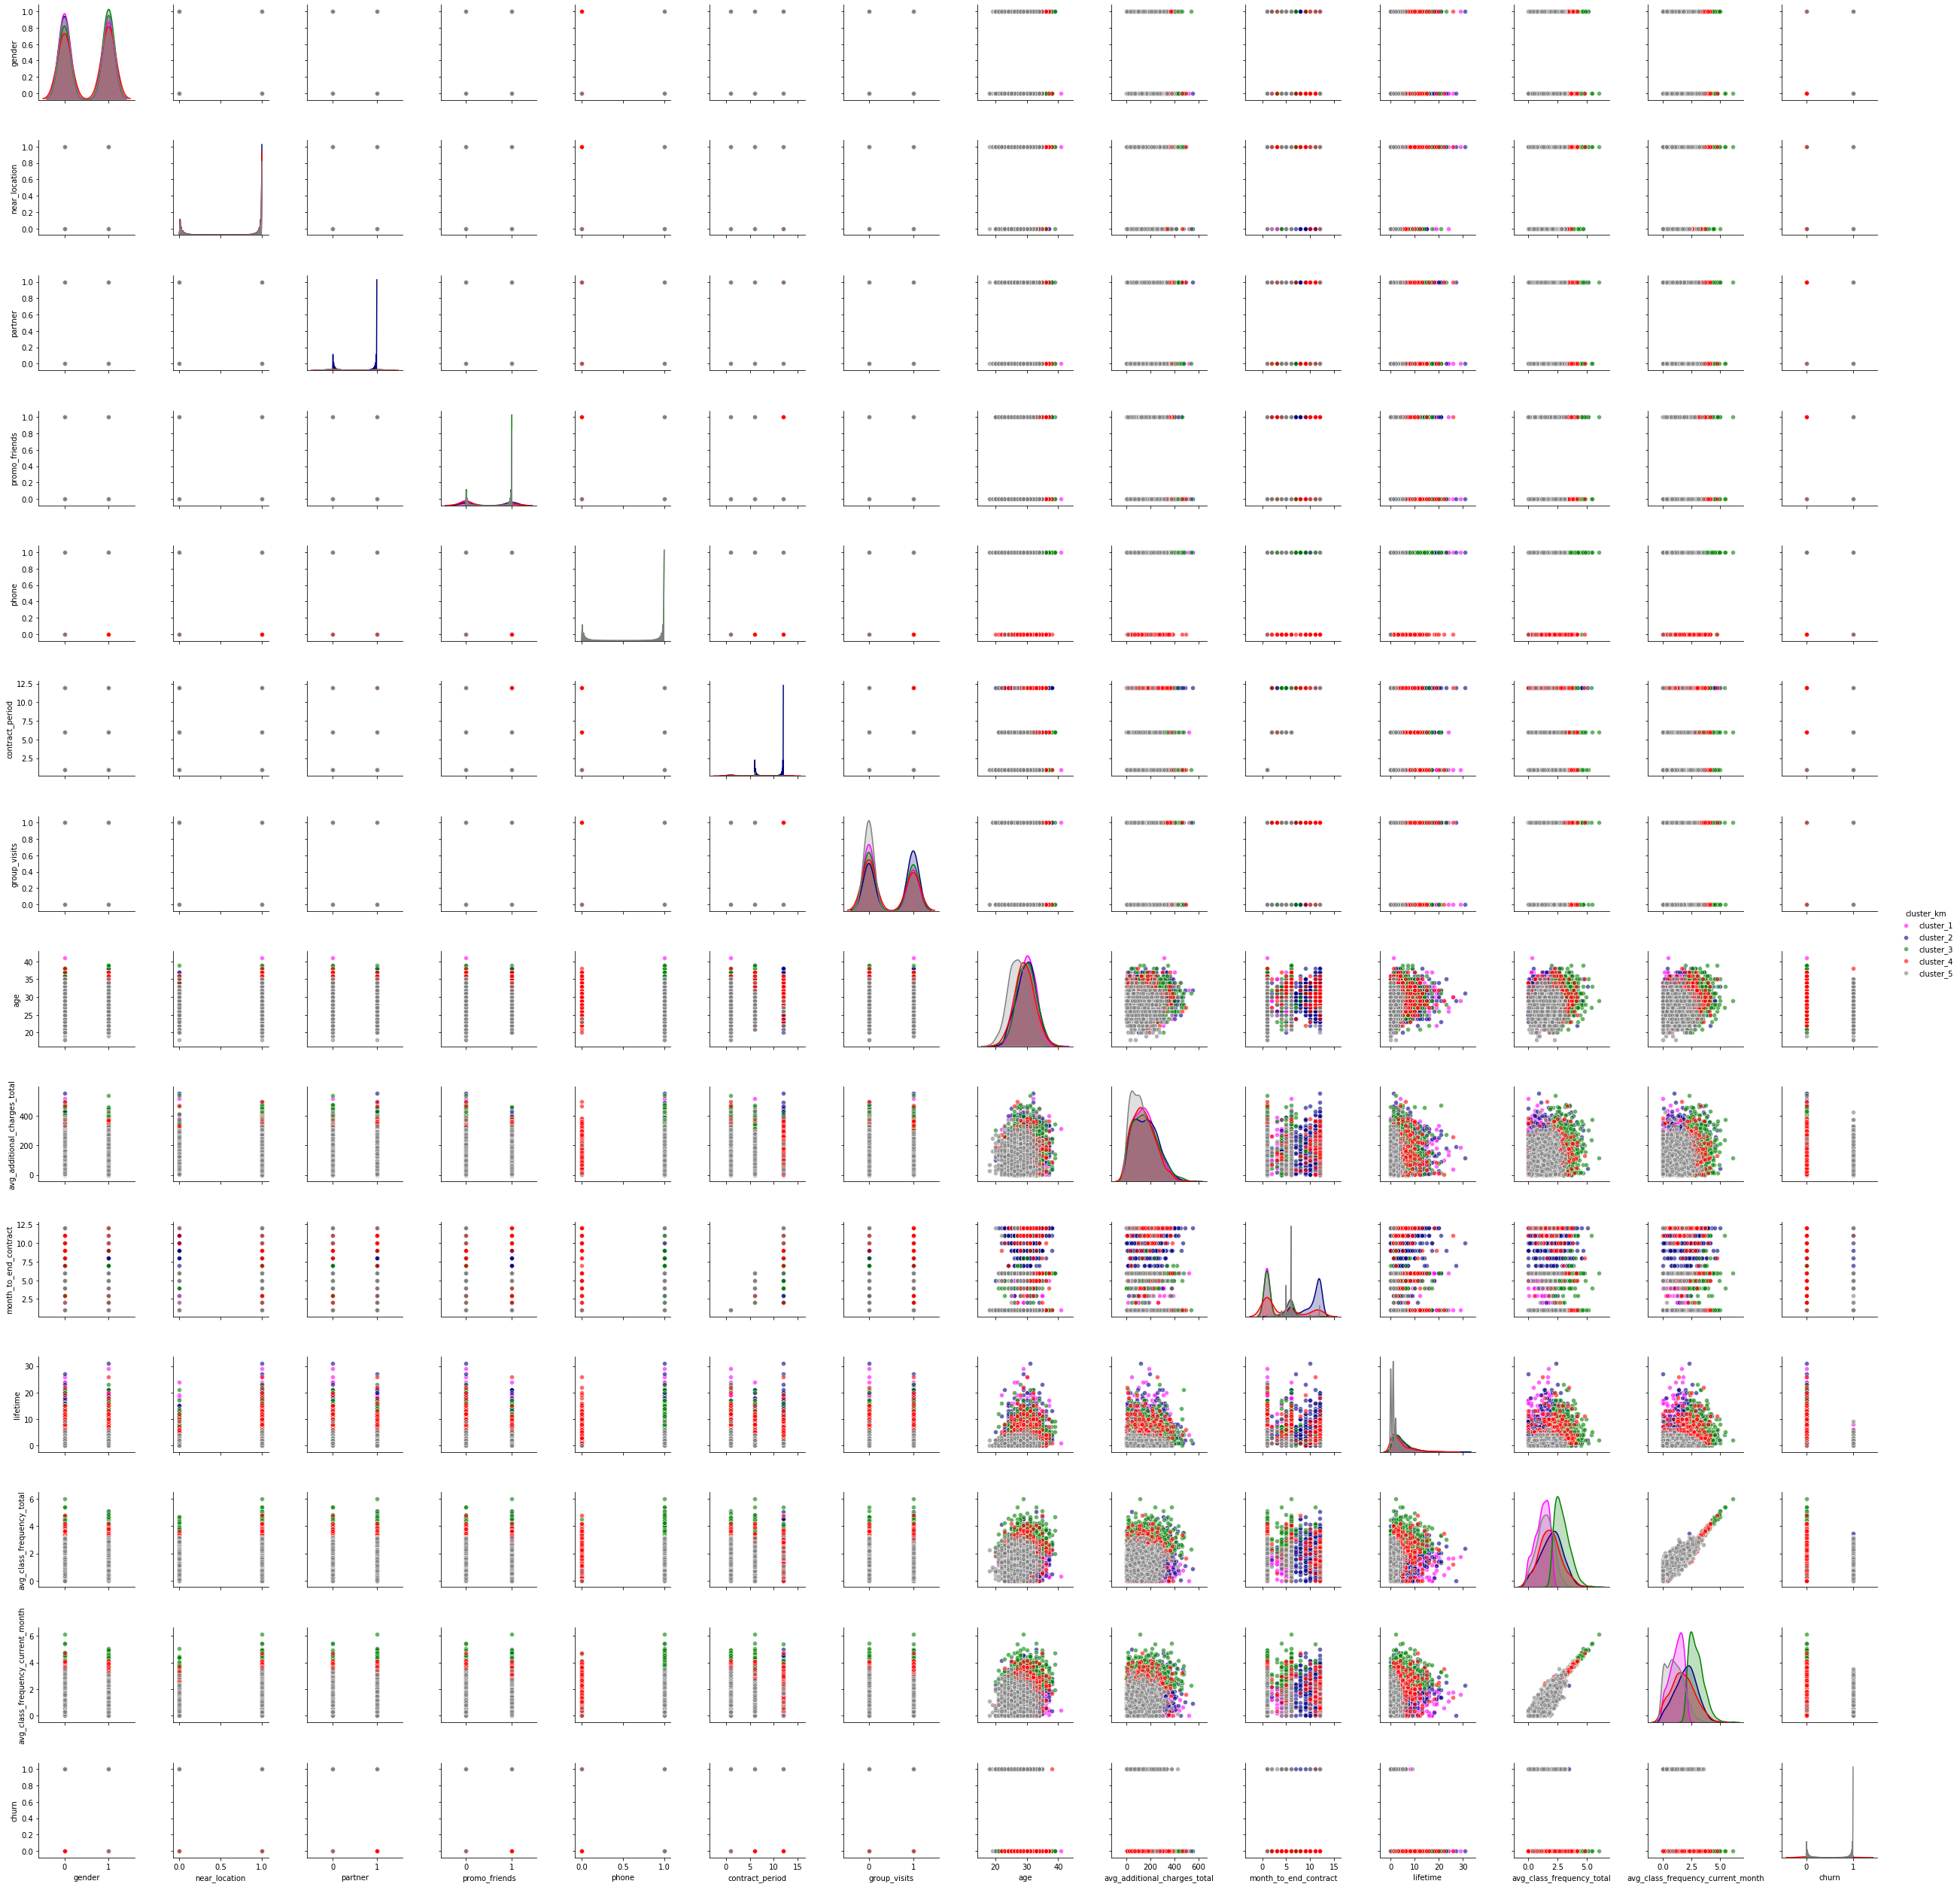

In [38]:
# строим распределение признаков
pair_plot_cluster(cluster_df, 0, 14)

**Построим отдельно распределение для признаков с индекса=7**

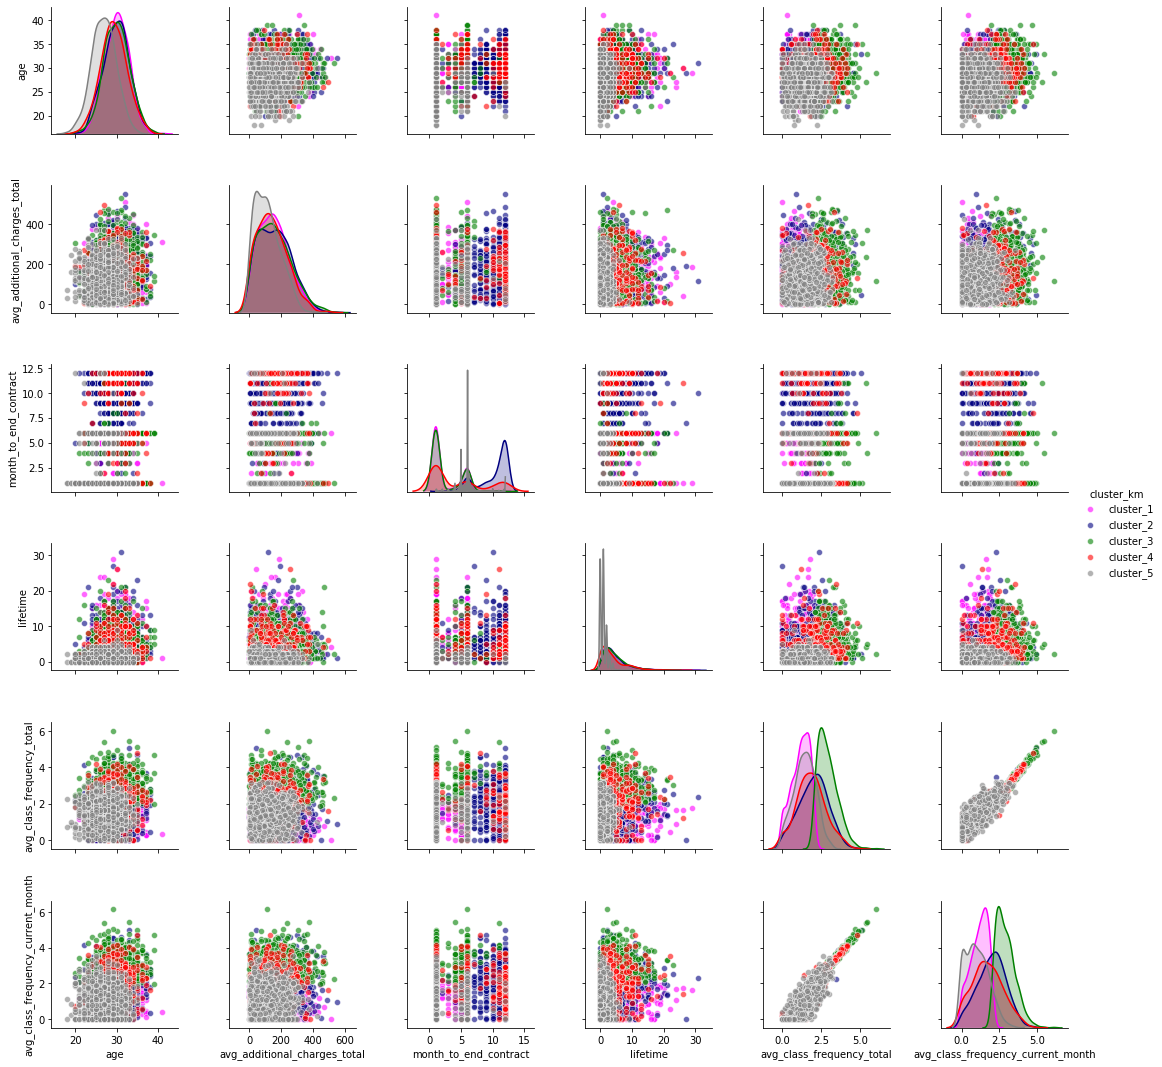

In [48]:
pair_plot_cluster(cluster_df, 7, 13)

**Выводы**
<a id='step_5'>

* Привлечение новых клиентов по акции "приведи друга"
* Активная реклама клуба в районе его расположения
* Персонализация программы скидок для действующих клиентов
* Повышение вовлеченности на групповых занятиях (например внедрение элементов геймификации), поощрение их посещения
* Расширение программы привлечения сотрудников компаний-партнеров и списка самих партнеров

[Вернуться к началу](#return_to_top)